# INSTALLATION DRIVER & LIBRARY

1. Install Microsoft ODBC Driver for Linux

In [14]:
!curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
!curl https://packages.microsoft.com/config/ubuntu/$(lsb_release -rs)/prod.list > /etc/apt/sources.list.d/mssql-release.list

!apt-get update
!ACCEPT_EULA=Y apt-get install -y msodbcsql18
# optional: for bcp and sqlcmd
!ACCEPT_EULA=Y apt-get install -y mssql-tools18
!echo 'export PATH="$PATH:/opt/mssql-tools18/bin"' >> ~/.bashrc
!source ~/.bashrc
# optional: for unixODBC development headers
!apt-get install -y unixodbc-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   983  100   983    0     0   4636      0 --:--:-- --:--:-- --:--:--  4615
OK
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    77  100    77    0     0    905      0 --:--:-- --:--:-- --:--:--   916
Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://packages.microsoft.com/ubuntu/18.04/prod bionic InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http:

2. Install Python Library

In [15]:
!apt-get --assume-yes install freetds-dev freetds-bin
!pip install pymssql

!apt-get install tdsodbc freetds-bin
!pip install pyodbc

! > /etc/odbcinst.ini
!echo -e "[FreeTDS]\nDescription=FreeTDS\nDriver=/usr/lib/x86_64-linux-gnu/odbc/libtdsodbc.so\nSetup=/usr/lib/x86_64-linux-gnu/odbc/libtdsS.so\nUsageCount=1" > /etc/odbcinst.ini
!cat /etc/odbcinst.ini

!pip install pmdarima

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freetds-dev is already the newest version (1.00.82-2ubuntu0.1).
freetds-bin is already the newest version (1.00.82-2ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tdsodbc is already the newest version (1.00.82-2ubuntu0.1).
freetds-bin is already the newest version (1.00.82-2ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-pyt

3. Install Pandas, Numpy, Seaborn

In [16]:
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")
# Importing the libraries
import os
import pyodbc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# STEP 1: GET DATA FROM SQL SERVER

1. Connect to SQL Server

In [17]:
conn = pyodbc.connect('DRIVER={FreeTDS};SERVER=222.252.14.117;PORT=1433;DATABASE=AdventureWorksDW2019;UID=hocvienda;PWD=dahkpim;TDS_Version=8.0')
cursor = conn.cursor()

2. Query SQL Server Data

In [18]:
# Get data with SQL Query
trend_data = pd.read_sql_query('''
SELECT [OrderDate] as date, SUM([SalesAmount]) as sales
FROM dbo.[FactInternetSales]
WhERE OrderDate >= '2011-01-01' and OrderDate <= '2013-12-28'
GROUP BY [OrderDate]
ORDER BY [OrderDate]
''', conn)
# Create data frame
df = pd.DataFrame(trend_data)
# Add month column
#df['month'] = df['date'].dt.month
#Read data
df.head(5)

,date,sales
0,2011-01-01,7156.54
1,2011-01-02,15012.18
2,2011-01-03,14313.08
3,2011-01-04,7855.64
4,2011-01-05,7855.64


3. Plot the data

Text(0, 0.5, 'Sales ($)')

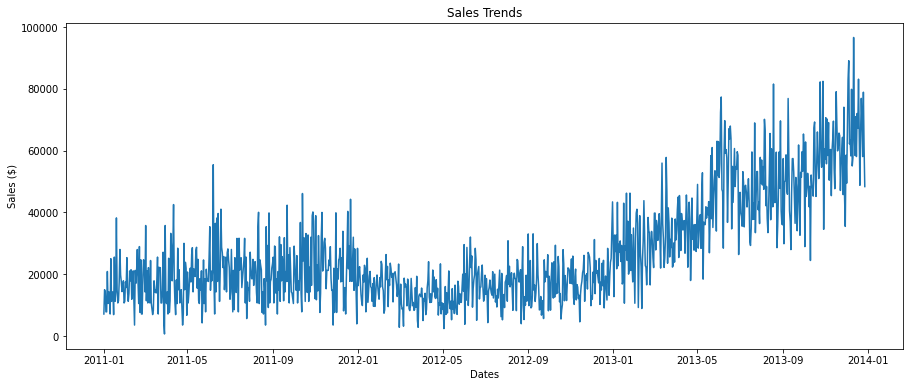

In [23]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=df['date'], y=df['sales'])
ax.set_title('Sales Trends')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')

# STEP 2: DECOMPISION OF TIME SERIES DATA

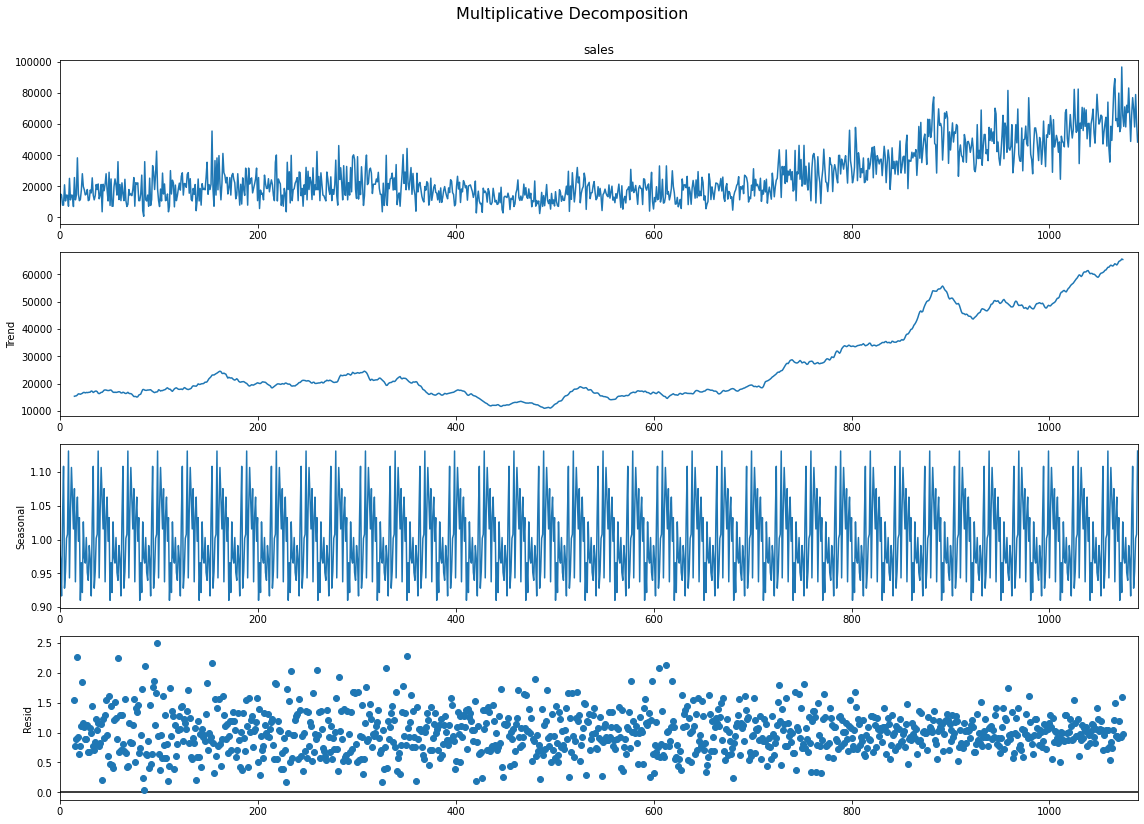

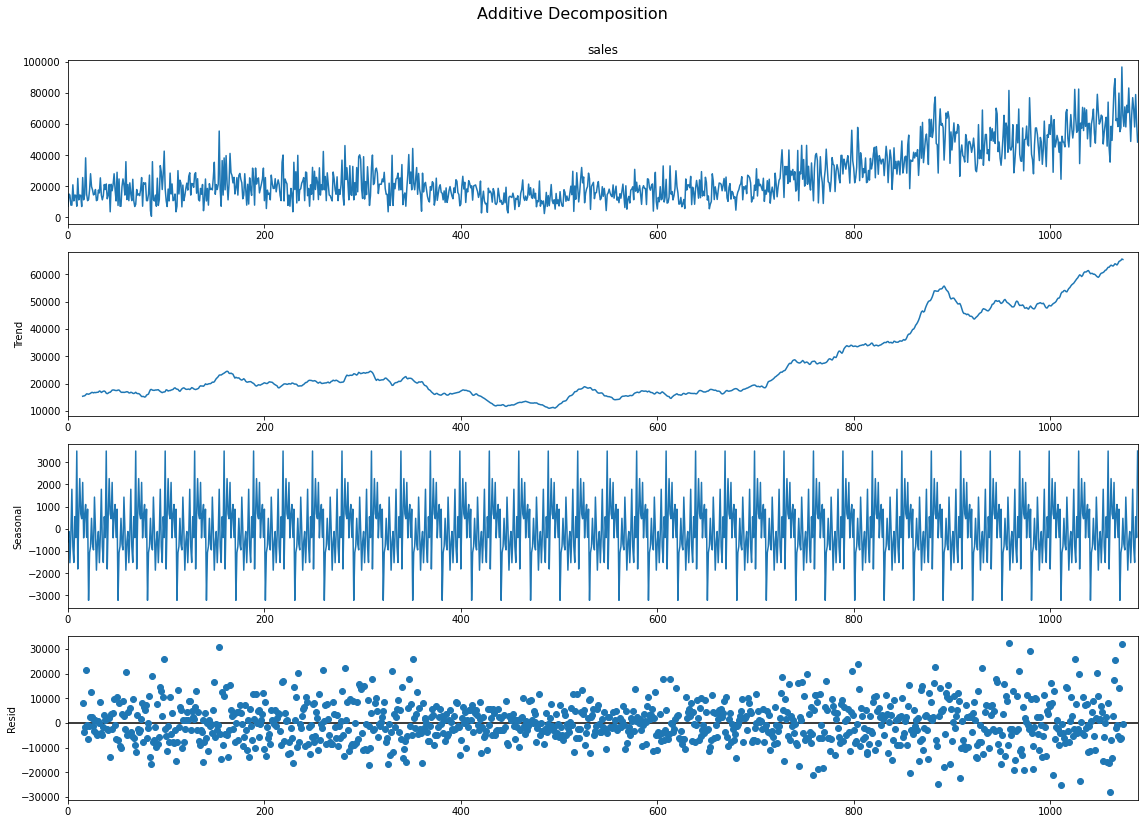

In [24]:
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df['sales'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(df['sales'], model='additive', period=30)
# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# STEP 3: STATIONARITY TEST WITH ADF

In [26]:
def check_stationarity(df): # df: array_like, 1d
 dftest = adfuller(df)
 adf = dftest[0]
 pvalue = dftest[1]
 critical_value = dftest[4]['5%']
 print('ADF Statistic: %f' % adf)
 print('p-value: %f' % pvalue)
 if (pvalue < 0.05) and (adf < critical_value): print('The series is stationary')
 else: print('The series is NOT stationary')

check_stationarity(df['sales'])

ADF Statistic: -0.270547
p-value: 0.929573
The series is NOT stationary


# STEP 4: SEASONALITY TEST WITH ACF

1. Run Auto Correlation Function (ACF)

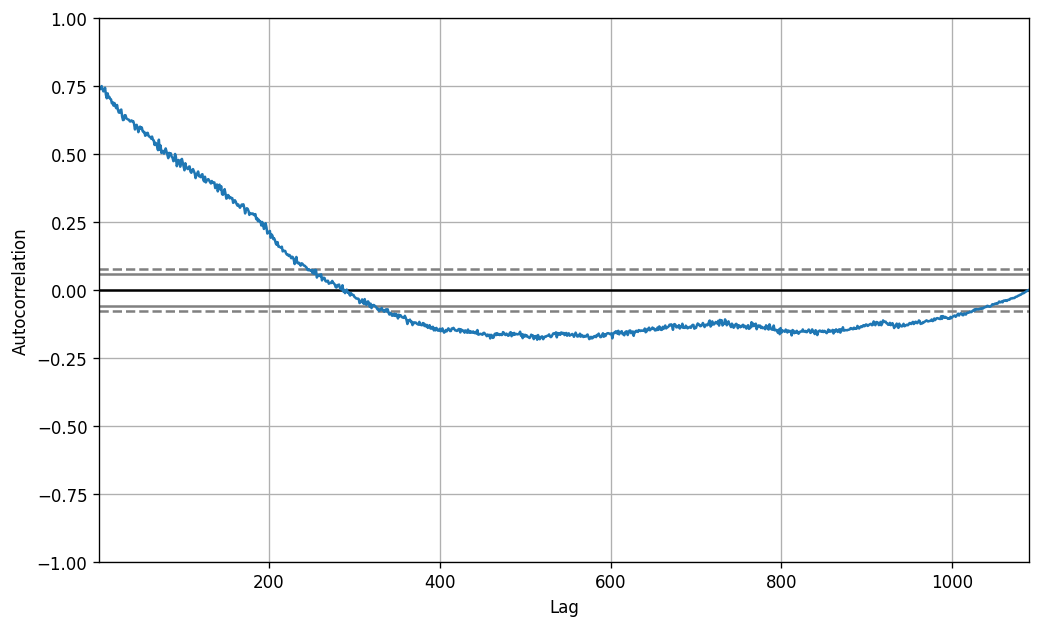

In [28]:
# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(df['sales'].tolist())

2. Run Lag Plot

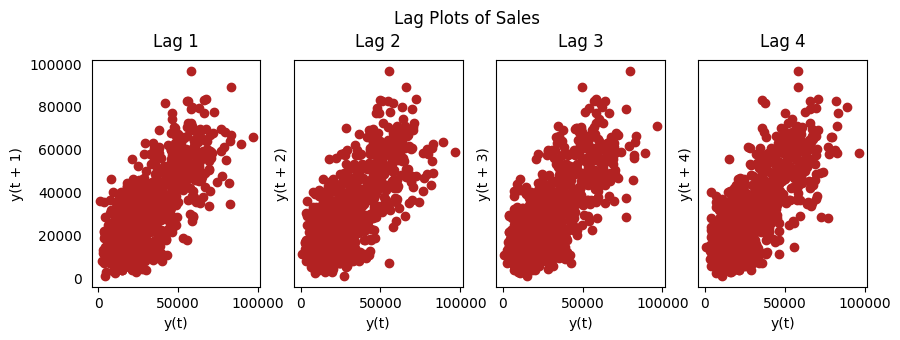

In [29]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
 lag_plot(df['sales'], lag=i+1, ax=ax, c='firebrick')
 ax.set_title('Lag ' + str(i+1))
fig.suptitle('Lag Plots of Sales', y=1.05)
plt.show()

# STEP 5: SPLIT TRAIN & TEST DATA

In [30]:
print('Dataset: %d' % len(df))
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train_df, test_df = df[0:train_size], df[train_size:]
test_df.index = test_df.index - train_size
print("Train Size:", train_size)
print(train_df)
print(test_df)

Dataset: 1090
Train Size: 872
          date    sales
0   2011-01-01  7156.54
1   2011-01-02 15012.18
2   2011-01-03 14313.08
3   2011-01-04  7855.64
4   2011-01-05  7855.64
..         ...      ...
867 2013-05-20 38025.50
868 2013-05-21 58402.96
869 2013-05-22 38000.76
870 2013-05-23 61004.75
871 2013-05-24 35148.85

[872 rows x 2 columns]
          date    sales
0   2013-05-25 42799.34
1   2013-05-26 50332.82
2   2013-05-27 53495.71
3   2013-05-28 45631.11
4   2013-05-29 33988.45
..         ...      ...
213 2013-12-24 69533.64
214 2013-12-25 58080.78
215 2013-12-26 78906.59
216 2013-12-27 60959.78
217 2013-12-28 48375.33

[218 rows x 2 columns]


# STEP 6: ARIMA MODEL TRAINING & PREDICTION

1. ARIMA Model Training

predicted=45037.035858, expected=42799.340000
predicted=46552.630805, expected=50332.820000
predicted=42417.750551, expected=53495.710000
predicted=48671.311262, expected=45631.110000
predicted=49969.331118, expected=33988.450000
predicted=44787.814840, expected=63052.590000
predicted=46970.968825, expected=51951.600000
predicted=49389.706575, expected=62935.460000
predicted=59201.090077, expected=51323.580000
predicted=55545.861457, expected=55816.680000
predicted=56747.781515, expected=72376.460000
predicted=59318.126351, expected=77359.340000
predicted=68173.413434, expected=47438.010000
predicted=66410.674028, expected=46708.250000
predicted=57673.493069, expected=28462.060000
predicted=41122.747408, expected=57790.020000
predicted=43945.283138, expected=69712.490000
predicted=51602.766234, expected=59151.700000
predicted=62246.329806, expected=60327.800000
predicted=63112.133748, expected=57660.180000
predicted=59063.127101, expected=36793.070000
predicted=51769.152290, expected=4

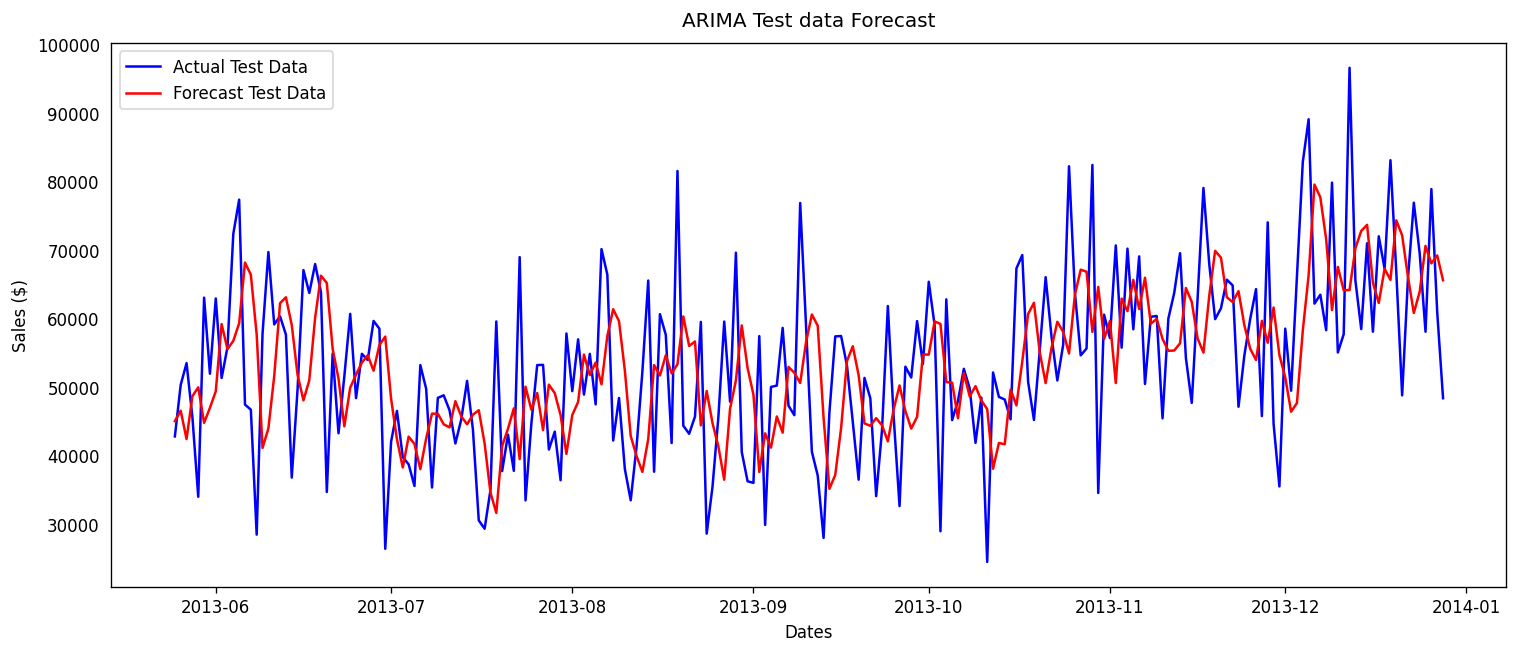

In [31]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
history = [x for x in train_df['sales']]
prediction_df = test_df.copy()

# walk-forward validation
for t in range(len(test_df)):
 model = ARIMA(history, order=(2,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 prediction_df['sales'][t] = yhat
 obs = test_df['sales'][t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test_df['sales'], prediction_df['sales']))
print(test_df)
print(prediction_df)
print('Test RMSE: %.3f' % rmse)
print(f'mean = {test_df.mean()}')
print(rmse/test_df.mean() * 100, '%')

fig, ax = plt.subplots(figsize=(15,6))
actual_line = sns.lineplot(x=test_df['date'], y=test_df['sales'], label='Actual Test Data', color='blue')
predict_line = sns.lineplot(x=prediction_df['date'], y=prediction_df['sales'], label='Forecast Test Data', color='red')

actual_line.legend()
predict_line.legend()
ax.set_title('ARIMA Test data Forecast')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')
plt.show()

2. ARIMA Model Prediction

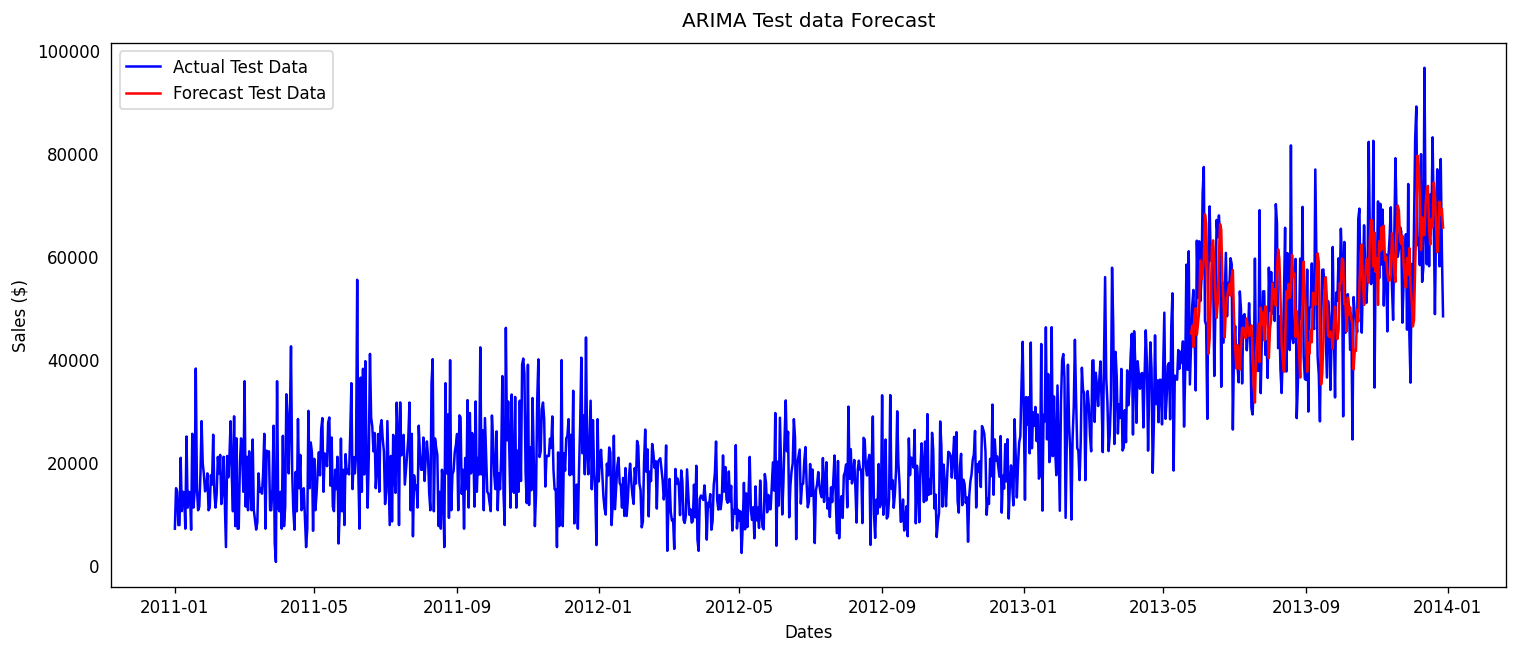

In [33]:
prediction_df.index = prediction_df.index + train_size
# print(prediction_df)
fig, ax = plt.subplots(figsize=(15,6))
actual_line = sns.lineplot(x=df['date'], y=df['sales'], label='Actual Test Data', color='blue')
predict_line = sns.lineplot(x=prediction_df['date'], y=prediction_df['sales'], label='Forecast Test Data', color='red')

actual_line.legend()
predict_line.legend()
ax.set_title('ARIMA Test data Forecast')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')
plt.show()

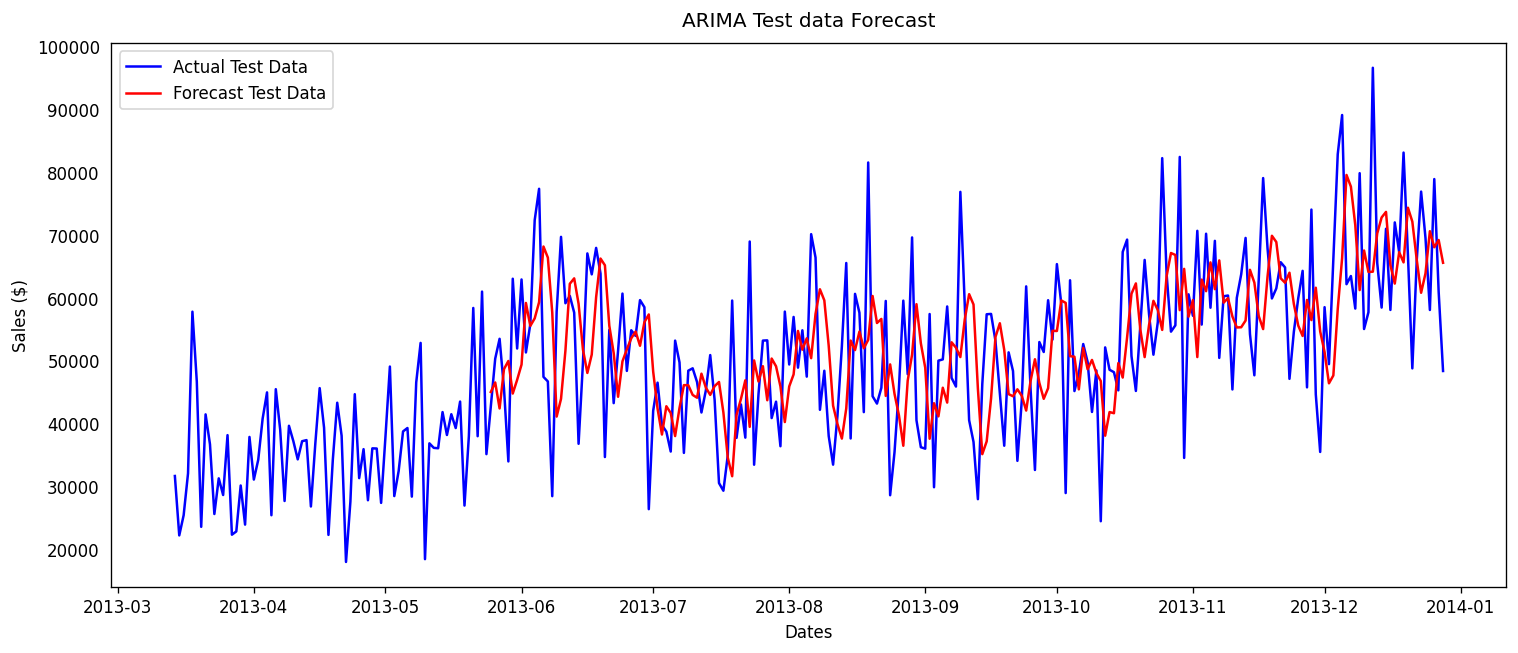

In [34]:
fig, ax = plt.subplots(figsize=(15,6))
actual_line = sns.lineplot(x=df[800:]['date'], y=df['sales'][800:], label='Actual Test Data', color='blue')
predict_line = sns.lineplot(x=prediction_df['date'], y=prediction_df['sales'], label='Forecast Test Data', color='red')

actual_line.legend()
predict_line.legend()
ax.set_title('ARIMA Test data Forecast')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')
plt.show()

Text(0, 0.5, 'Sales ($)')

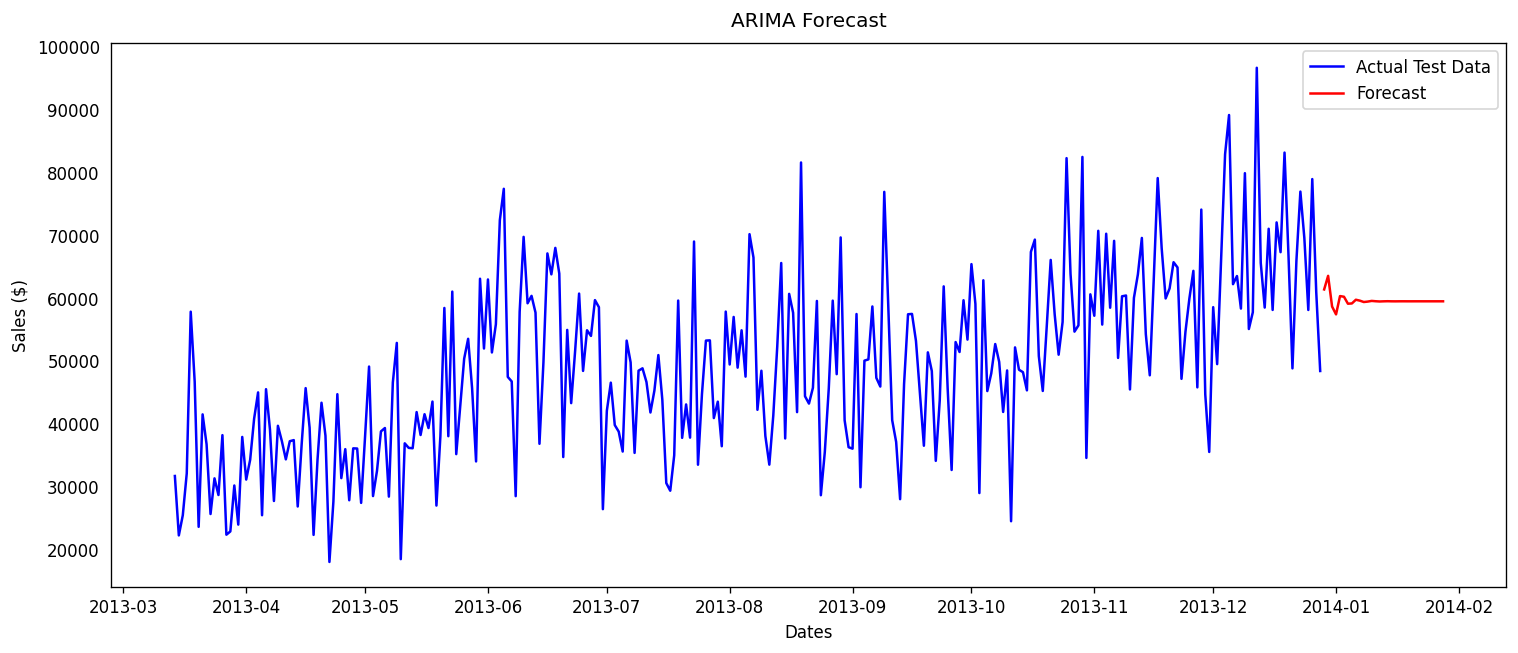

In [35]:
future_df = pd.DataFrame(pd.date_range(start='2013-12-29', periods = 31),columns=['date'])
# for t in range(len(future_df)):
# output = model_fit.forecast()
# future_forecasts.append(output[0])
# future_forecasts = model_fit.forecast(steps=len(future_df))
# future_df['sales'] = future_forecasts
# print(future_df)
history = [x for x in df['sales']]
future_forecasts = []
# walk-forward validation
for t in range(len(future_df)):
 model = ARIMA(history, order=(3,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 future_forecasts.append(yhat)
 history.append(yhat)
future_df['sales'] = future_forecasts
fig, ax = plt.subplots(figsize=(15,6))

actual_line = sns.lineplot(x=df[800:]['date'], y=df['sales'][800:], label='Actual Test Data', color='blue')
predict_line = sns.lineplot(x=future_df['date'], y=future_df['sales'], label='Forecast', color ='red')
actual_line.legend()
predict_line.legend()
ax.set_title('ARIMA Forecast')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')